# Imports and Functions

In [1]:
import math 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton
import matplotlib.path as path
from matplotlib.colors import ListedColormap
import numpy as np
from numpy import load
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KDTree
%matplotlib notebook

global selection_model
global threshold
threshold = 20 #300 works
import random
from random import randint

global cm
global cm_bright
global wales
global maxiter
global numcoords
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

wales = load('walesoutline1.npy')
wales = path.Path(wales)


maxiter = 21
numcoords = 2
selection_model = 1 #0 for 0.5, 1 for isolated, 2 for random, 3 for best

In [2]:
import math
def normpdf(x, mean, sd):
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

In [3]:
def xnew(x): 
    return (-5)+(((x+5)*(10+5))/(51+5))
def ynew(y): 
    return ((y+2)*(15))/(55)

def branin(x, a=1, b=5.1/(4*(np.pi**2)), c=5/np.pi, r=6, s=10, t=1/(8*np.pi), noise=0.1):
       
    return a*(x[1]-(b*(x[0]**2))+c*x[0]-r)**2+(s*(1-t)*np.cos(x[0]))+s

def braninColor(x, threshold):
    
    if branin((xnew(x[0]),xnew(x[1])))>threshold:
        return 1
    else:
        return 0   

In [4]:
def calculateModel():
    
    global X
    global Z
    global Z_model_pred
    global Znew
    global ZBranin
    global xx,yy
    global Big_df
    global Big_df_land


    x_min, x_max = -5, 51 
    y_min, y_max = -2, 53
    h = .5  # step size in the mesh

    Coords_df = pd.DataFrame(coords,columns=['XPos','YPos','Type'])
    DT_X_Values = Coords_df.drop(['Type'],axis=1)

    X = DT_X_Values.to_numpy().tolist()
    X = np.array(X)

    DT_Y_Values = Coords_df.drop(['XPos'],axis=1)
    DT_Y_Values = DT_Y_Values.drop(['YPos'],axis=1)
    y = DT_Y_Values.to_numpy().ravel()



    clf = ExtraTreesClassifier(n_estimators = 100)
    clf.fit(X, y)
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
    
    ZBranin = []
    branincoords = np.c_[xx.ravel(), yy.ravel()]
    for i in range(12320):
        ZBranin.append(braninColor(branincoords[i],20))



    Z_model_prob = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z_model_prob = Z_model_prob.reshape(xx.shape)                                                      #Z is [model_probs]
    Z_model_pred = clf.predict(np.c_[xx.ravel(), yy.ravel()])[:]                        #Z_model_pred is [model_predictions]

    Big_df = pd.DataFrame(xx.ravel(), columns=['xx'])#
    Big_df.insert(1, 'yy',yy.ravel())
    Big_df.insert(2, 'Z_model_predictions', Z_model_pred.ravel())
    Big_df.insert(3, 'Z_model_predictions_flattened', 0)
    Big_df.insert(4, 'Z_model_probs', Z_model_prob.ravel())
    Big_df.insert(5, 'Z_model_probs_flattened_SEA', 0)
    Big_df.insert(6, 'Z_model_probs_flattened_0', 0)
    Big_df.insert(7, 'Surrogate_model_predictions', ZBranin)
    Big_df.insert(8, 'Surrogate_model_predictions_flattened', 0)

    for i in range(12320):

        if (wales.contains_points([(Big_df.iat[i,0],Big_df.iat[i,1])])[0]):
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_probs']
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = Big_df.iloc[i]['Surrogate_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = Big_df.iloc[i]['Z_model_probs']

        else:
            Big_df.loc[i, 'Z_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = 'SEA'
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = 0

    Z_model_predictions = Big_df["Z_model_predictions"].to_numpy()
    Z_model_predictions_flattened = Big_df["Z_model_predictions_flattened"].to_numpy()
    Z_model_probs = Big_df["Z_model_probs"].to_numpy()
#     Z_model_probs_flattened = Big_df["Z_model_probs_flattened"].to_numpy()
    Surrogate_model_predictions = Big_df["Surrogate_model_predictions"].to_numpy()
    Surrogate_model_predictions_flattened = Big_df["Surrogate_model_predictions_flattened"].to_numpy()

    Big_df_land = Big_df[Big_df['Z_model_predictions_flattened'] != 'SEA']

    Contour_model = Big_df["Z_model_probs_flattened_0"].to_numpy()
    Contour_model = Contour_model.reshape(xx.shape) 


    plt.cla()
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic_r')
    # plt.axis("off")
    plt.grid()
    ax.contourf(xx, yy, Contour_model, 40, cmap=cm, alpha=
                0.4)

    plt.plot()

    plt.show()


In [5]:
def find_isolated_point():
       
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]

    testpoints = tmp_df[['xx','yy']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        if dist>maxdist:
            maxdist = dist
            maxind = ind
            ifinal = i

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)
    plt.plot()
    plt.show()
    fig1.show()
#     print('isolated', testpoints[ifinal])
    return testpoints[ifinal]
    
def find0_5():
    
    tmp_df = Big_df.iloc[(Big_df['Z_model_probs_flattened_0']-0.50).abs().argsort()[:2]]
    value = randint(0, len(tmp_df.index)-1)
    uncertain_coord = [tmp_df.iloc[value]['xx'],tmp_df.iloc[value]['yy']]
        
    ax.scatter(uncertain_coord[0], uncertain_coord[1], c='#00FF00', s=25)
    plt.plot()
    plt.show()    
    fig1.show()
      
#     print('0_5', uncertain_coord)
    return uncertain_coord

def random_point():
    
    tmp_df = Big_df_land.iloc[:, :]
    testpoints = tmp_df[['xx','yy']].to_numpy()
                    
    ifinal = randint(0,len(testpoints.tolist()))
    
    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()
    
    fig1.show()
    
    return testpoints[ifinal]

def best():
    
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]
    score = 0

    testpoints = tmp_df[['xx','yy']].to_numpy()
    testpoints1 = tmp_df[['Z_model_probs']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        prob = testpoints1[i]
        tmp_score = dist*normpdf(prob,0.5,0.05)
        if tmp_score>score:
            ifinal = i
            distfinal = dist
            probfinal = prob
            score = tmp_score

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()

    fig1.show()
    
    find0_5()
    find_isolated_point()
    
    print(distfinal)
    print(probfinal)
    print(score)
    print('best',testpoints[ifinal])

    return testpoints[ifinal]
    
    



In [6]:
def Accuracy():
    
    correctPredictions = 0
    incorrectPredictions = 0

    for i in range(len(Big_df_land.index)):
        if ((Big_df_land.iloc[i]["Z_model_predictions"])==(Big_df_land.iloc[i]["Surrogate_model_predictions"])):
            correctPredictions+=1
        else:
            incorrectPredictions+=1


    accuracy = (correctPredictions)/((
    incorrectPredictions+correctPredictions))
    accuracyArray.append(accuracy)

    print('Accuracy is',accuracy)
    

def printGraph():
    
    xAxis = []
    for i in range(len(accuracyArray)):
        xAxis.append(i+1)

    plt.scatter(xAxis, accuracyArray) 
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy over time')
    plt.ylim(0.3, 1.0)  
    plt.show()

# Plot first graph

experiment:  0


<IPython.core.display.Javascript object>


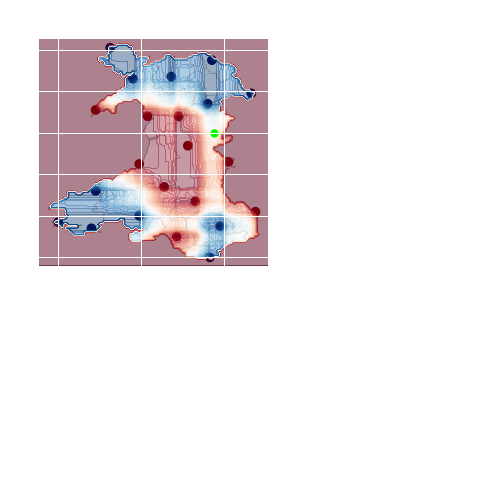

iteration  1
Accuracy is 0.5141318977119784
iteration  2
Accuracy is 0.485483560853682
iteration  3
Accuracy is 0.6308402230340319
iteration  4
Accuracy is 0.6546817919630841
iteration  5
Accuracy is 0.7271678523360892
iteration  6
Accuracy is 0.690636416073832
iteration  7
Accuracy is 0.7686983272447606
iteration  8
Accuracy is 0.7388963660834454
iteration  9
Accuracy is 0.7656219957700442
iteration  10
Accuracy is 0.7790809459719285
iteration  11
Accuracy is 0.8294558738704095
iteration  12
Accuracy is 0.8198423380119207
iteration  13
Accuracy is 0.8319553931936167
iteration  14
Accuracy is 0.8113824264564506
iteration  15
Accuracy is 0.8319553931936167
iteration  16
Accuracy is 0.798308017688906
iteration  17
Accuracy is 0.8133051336281484
iteration  18
Accuracy is 0.8075370121130552
iteration  19
Accuracy is 0.8071524706787157
iteration  20
Accuracy is 0.8663718515670064
iteration  21
Accuracy is 0.8390694097288983
experiment:  1


<IPython.core.display.Javascript object>


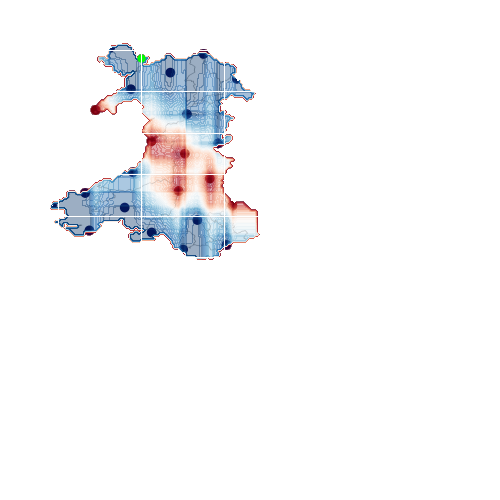

iteration  1
Accuracy is 0.4879830801768891
iteration  2
Accuracy is 0.5583541626610268
iteration  3
Accuracy is 0.5389348202268794
iteration  4
Accuracy is 0.6318015766198808
iteration  5
Accuracy is 0.7810036531436262
iteration  6
Accuracy is 0.7819650067294751
iteration  7
Accuracy is 0.7756200730628725
iteration  8
Accuracy is 0.7106325706594886
iteration  9
Accuracy is 0.7277446644875986
iteration  10
Accuracy is 0.8561815035570083
iteration  11
Accuracy is 0.8258027302441838
iteration  12
Accuracy is 0.8365698904056912
iteration  13
Accuracy is 0.8300326860219188
iteration  14
Accuracy is 0.8398384925975774
iteration  15
Accuracy is 0.8304172274562585
iteration  16
Accuracy is 0.7979234762545664
iteration  17
Accuracy is 0.7921553547394732
iteration  18
Accuracy is 0.7817727360123053
iteration  19
Accuracy is 0.848682945587387
iteration  20
Accuracy is 0.8204191501634301
iteration  21
Accuracy is 0.8217650451836185
experiment:  2


<IPython.core.display.Javascript object>


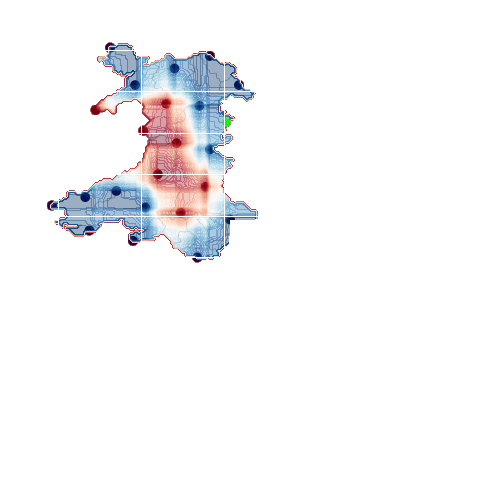

iteration  1
Accuracy is 0.4814458757931167
iteration  2
Accuracy is 0.6969813497404346
iteration  3
Accuracy is 0.7460103826187272
iteration  4
Accuracy is 0.6971736204576043
iteration  5
Accuracy is 0.761584310709479
iteration  6
Accuracy is 0.7215920015381657
iteration  7
Accuracy is 0.7550471063257066
iteration  8
Accuracy is 0.7139011728513748
iteration  9
Accuracy is 0.7479330897904249
iteration  10
Accuracy is 0.817150547971544
iteration  11
Accuracy is 0.7958084983656989
iteration  12
Accuracy is 0.7415881561238223
iteration  13
Accuracy is 0.8627187079407806
iteration  14
Accuracy is 0.8419534704864449
iteration  15
Accuracy is 0.8559892328398385
iteration  16
Accuracy is 0.8358008075370121
iteration  17
Accuracy is 0.8719477023649298
iteration  18
Accuracy is 0.8925206691020957
iteration  19
Accuracy is 0.8600269179004038
iteration  20
Accuracy is 0.855604691405499
iteration  21
Accuracy is 0.8750240338396462
experiment:  3


<IPython.core.display.Javascript object>


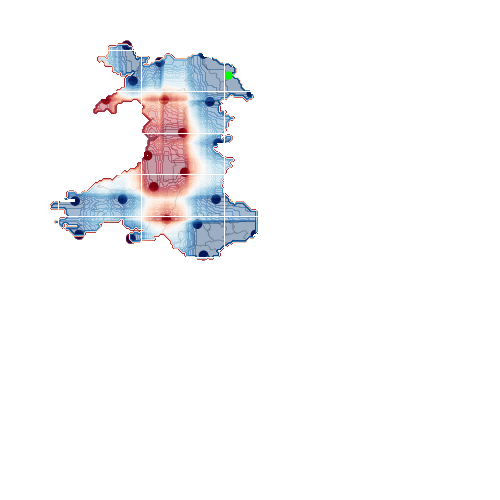

iteration  1
Accuracy is 0.44952893674293404
iteration  2
Accuracy is 0.5818111901557392
iteration  3
Accuracy is 0.5989232839838493
iteration  4
Accuracy is 0.5900788309940396
iteration  5
Accuracy is 0.6410305710440299
iteration  6
Accuracy is 0.6673716592962892
iteration  7
Accuracy is 0.7121707363968468
iteration  8
Accuracy is 0.6506441069025187
iteration  9
Accuracy is 0.7017881176696789
iteration  10
Accuracy is 0.7046721784272255
iteration  11
Accuracy is 0.7115939242453374
iteration  12
Accuracy is 0.759853874254951
iteration  13
Accuracy is 0.7575466256489136
iteration  14
Accuracy is 0.8036915977696597
iteration  15
Accuracy is 0.8256104595270141
iteration  16
Accuracy is 0.8525283599307826
iteration  17
Accuracy is 0.8340703710824842
iteration  18
Accuracy is 0.8309940396077677
iteration  19
Accuracy is 0.846952509132859
iteration  20
Accuracy is 0.8402230340319169
iteration  21
Accuracy is 0.8411843876177658
experiment:  4


<IPython.core.display.Javascript object>


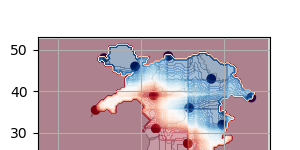

iteration  1
Accuracy is 0.6073831955393194
iteration  2
Accuracy is 0.792347625456643
iteration  3
Accuracy is 0.746202653335897
iteration  4
Accuracy is 0.7558161891943856
iteration  5
Accuracy is 0.7173620457604307
iteration  6
Accuracy is 0.7694674101134398
iteration  7
Accuracy is 0.7279369352047683
iteration  8
Accuracy is 0.7500480676792924
iteration  9
Accuracy is 0.7110171120938281
iteration  10
Accuracy is 0.746202653335897
iteration  11
Accuracy is 0.756393001345895
iteration  12
Accuracy is 0.7348586810228802
iteration  13
Accuracy is 0.7608152278407998
iteration  14
Accuracy is 0.7756200730628725
iteration  15
Accuracy is 0.7471640069217458
iteration  16
Accuracy is 0.7869640453758893
iteration  17
Accuracy is 0.7836954431840031
iteration  18
Accuracy is 0.8169582772543742
iteration  19
Accuracy is 0.8425302826379543
iteration  20
Accuracy is 0.8379157854258796
iteration  21
Accuracy is 0.8625264372236109
experiment:  5


<IPython.core.display.Javascript object>


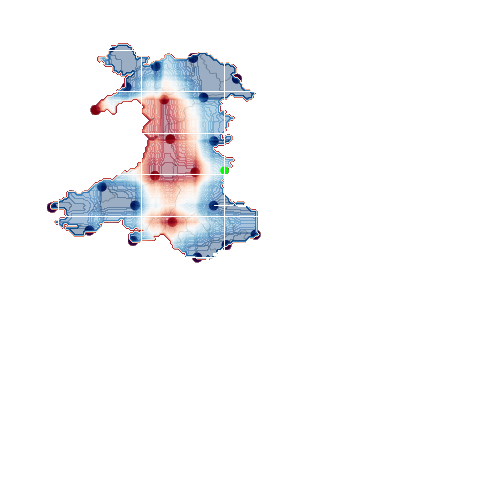

iteration  1
Accuracy is 0.4704864449144395
iteration  2
Accuracy is 0.7356277638915593
iteration  3
Accuracy is 0.6621803499327052
iteration  4
Accuracy is 0.796577581234378
iteration  5
Accuracy is 0.7177465871947702
iteration  6
Accuracy is 0.7240915208613729
iteration  7
Accuracy is 0.7185156700634493
iteration  8
Accuracy is 0.7146702557200538
iteration  9
Accuracy is 0.7052489905787349
iteration  10
Accuracy is 0.7077485099019419
iteration  11
Accuracy is 0.6898673332051528
iteration  12
Accuracy is 0.7233224379926937
iteration  13
Accuracy is 0.7285137473562776
iteration  14
Accuracy is 0.7758123437800423
iteration  15
Accuracy is 0.7919630840223034
iteration  16
Accuracy is 0.8100365314362623
iteration  17
Accuracy is 0.8392616804460681
iteration  18
Accuracy is 0.8679100173043646
iteration  19
Accuracy is 0.8654104979811574
iteration  20
Accuracy is 0.8519515477792732
iteration  21
Accuracy is 0.8475293212843684
experiment:  6


<IPython.core.display.Javascript object>


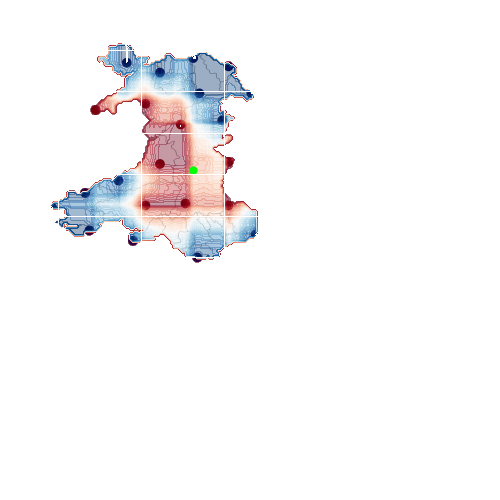

iteration  1
Accuracy is 0.5012497596616036
iteration  2
Accuracy is 0.6758315708517593
iteration  3
Accuracy is 0.7392809075177851
iteration  4
Accuracy is 0.6879446260334551
iteration  5
Accuracy is 0.7748509901941935
iteration  6
Accuracy is 0.7323591616996732
iteration  7
Accuracy is 0.776965968083061
iteration  8
Accuracy is 0.7758123437800423
iteration  9
Accuracy is 0.7456258411843876
iteration  10
Accuracy is 0.761584310709479
iteration  11
Accuracy is 0.7850413382041915
iteration  12
Accuracy is 0.8033070563353202
iteration  13
Accuracy is 0.8236877523553163
iteration  14
Accuracy is 0.7835031724668333
iteration  15
Accuracy is 0.7746587194770237
iteration  16
Accuracy is 0.821380503749279
iteration  17
Accuracy is 0.8234954816381466
iteration  18
Accuracy is 0.8084983656989041
iteration  19
Accuracy is 0.8652182272639877
iteration  20
Accuracy is 0.8523360892136128
iteration  21
Accuracy is 0.8706018073447414
experiment:  7


<IPython.core.display.Javascript object>


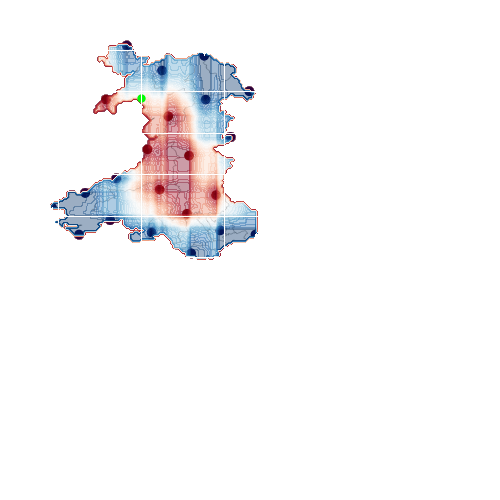

iteration  1
Accuracy is 0.5954624110747934
iteration  2
Accuracy is 0.8248413766583349
iteration  3
Accuracy is 0.8140742164968275
iteration  4
Accuracy is 0.7065948855989233
iteration  5
Accuracy is 0.7006344933666603
iteration  6
Accuracy is 0.6783310901749664
iteration  7
Accuracy is 0.6523745433570467
iteration  8
Accuracy is 0.6700634493366661
iteration  9
Accuracy is 0.7506248798308017
iteration  10
Accuracy is 0.7517785041338204
iteration  11
Accuracy is 0.7800422995577774
iteration  12
Accuracy is 0.7785041338204192
iteration  13
Accuracy is 0.787156316093059
iteration  14
Accuracy is 0.8090751778504134
iteration  15
Accuracy is 0.7990771005575851
iteration  16
Accuracy is 0.8338781003653144
iteration  17
Accuracy is 0.8407998461834263
iteration  18
Accuracy is 0.8352239953855027
iteration  19
Accuracy is 0.8627187079407806
iteration  20
Accuracy is 0.861565083637762
iteration  21
Accuracy is 0.8509901941934244
experiment:  8


<IPython.core.display.Javascript object>


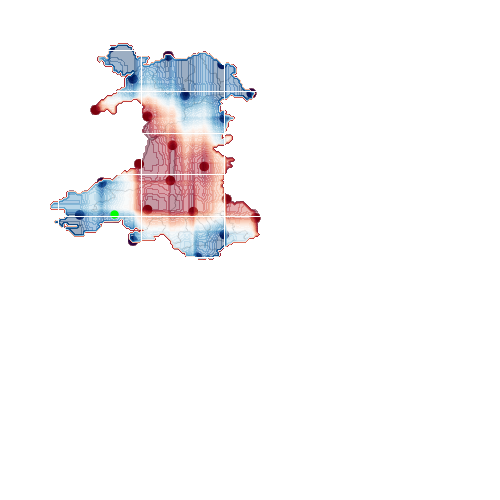

iteration  1
Accuracy is 0.5247067871563161
iteration  2
Accuracy is 0.6091136319938474
iteration  3
Accuracy is 0.7012113055181696
iteration  4
Accuracy is 0.6464141511247837
iteration  5
Accuracy is 0.6927513939626995
iteration  6
Accuracy is 0.7283214766391078
iteration  7
Accuracy is 0.6823687752355316
iteration  8
Accuracy is 0.702557200538358
iteration  9
Accuracy is 0.6846760238415689
iteration  10
Accuracy is 0.7433185925783503
iteration  11
Accuracy is 0.7562007306287253
iteration  12
Accuracy is 0.704287636992886
iteration  13
Accuracy is 0.7381272832147664
iteration  14
Accuracy is 0.8159969236685253
iteration  15
Accuracy is 0.7985002884060758
iteration  16
Accuracy is 0.8190732551432417
iteration  17
Accuracy is 0.8090751778504134
iteration  18
Accuracy is 0.8579119400115363
iteration  19
Accuracy is 0.8456066141126707
iteration  20
Accuracy is 0.8577196692943665
iteration  21
Accuracy is 0.8729090559507787
experiment:  9


<IPython.core.display.Javascript object>


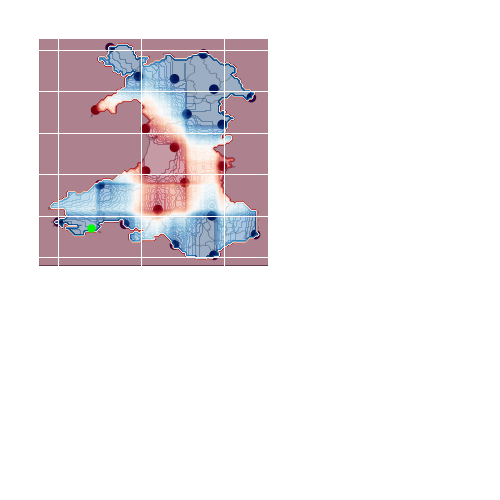

iteration  1
Accuracy is 0.5114401076716016
iteration  2
Accuracy is 0.7094789463564699
iteration  3
Accuracy is 0.7265910401845799
iteration  4
Accuracy is 0.8073447413958854
iteration  5
Accuracy is 0.7237069794270332
iteration  6
Accuracy is 0.7621611228609882
iteration  7
Accuracy is 0.7192847529321285
iteration  8
Accuracy is 0.7106325706594886
iteration  9
Accuracy is 0.7177465871947702
iteration  10
Accuracy is 0.7283214766391078
iteration  11
Accuracy is 0.7090944049221304
iteration  12
Accuracy is 0.7112093828109979
iteration  13
Accuracy is 0.73505095174005
iteration  14
Accuracy is 0.8081138242645645
iteration  15
Accuracy is 0.8069601999615459
iteration  16
Accuracy is 0.8063833878100365
iteration  17
Accuracy is 0.836762161122861
iteration  18
Accuracy is 0.8534897135166314
iteration  19
Accuracy is 0.8477215920015382
iteration  20
Accuracy is 0.8406075754662565
iteration  21
Accuracy is 0.857335127860027
experiment:  10


<IPython.core.display.Javascript object>


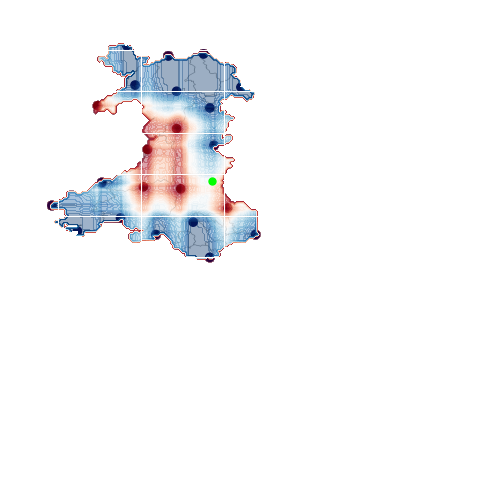

iteration  1
Accuracy is 0.5079792347625457
iteration  2
Accuracy is 0.6014228033070563
iteration  3
Accuracy is 0.6877523553162853
iteration  4
Accuracy is 0.7192847529321285
iteration  5
Accuracy is 0.7485099019419342
iteration  6
Accuracy is 0.7240915208613729
iteration  7
Accuracy is 0.715439338588733
iteration  8
Accuracy is 0.6925591232455297
iteration  9
Accuracy is 0.715439338588733
iteration  10
Accuracy is 0.7087098634877909
iteration  11
Accuracy is 0.8627187079407806
iteration  12
Accuracy is 0.846952509132859
iteration  13
Accuracy is 0.8329167467794655
iteration  14
Accuracy is 0.8279177081330513
iteration  15
Accuracy is 0.8404153047490868
iteration  16
Accuracy is 0.8231109402038069
iteration  17
Accuracy is 0.8115746971736204
iteration  18
Accuracy is 0.8177273601230532
iteration  19
Accuracy is 0.8694481830417228
iteration  20
Accuracy is 0.8557969621226688
iteration  21
Accuracy is 0.8288790617189002
experiment:  11


<IPython.core.display.Javascript object>


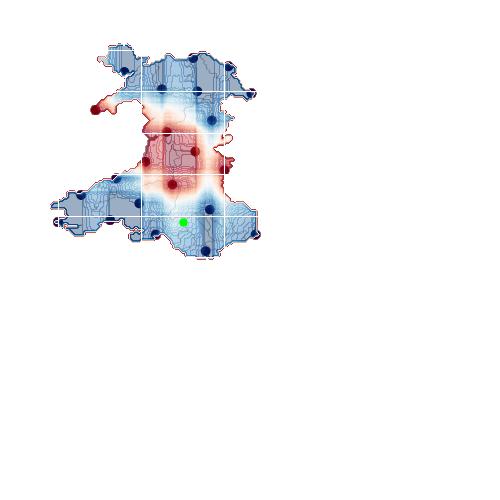

iteration  1
Accuracy is 0.5643145548932897
iteration  2
Accuracy is 0.6081522784079985
iteration  3
Accuracy is 0.6514131897711979
iteration  4
Accuracy is 0.6639107863872332
iteration  5
Accuracy is 0.6875600845991156
iteration  6
Accuracy is 0.733320515285522
iteration  7
Accuracy is 0.7125552778311863
iteration  8
Accuracy is 0.708517592770621
iteration  9
Accuracy is 0.7215920015381657
iteration  10
Accuracy is 0.7646606421841954
iteration  11
Accuracy is 0.7985002884060758
iteration  12
Accuracy is 0.8411843876177658
iteration  13
Accuracy is 0.845222072678331
iteration  14
Accuracy is 0.8088829071332436
iteration  15
Accuracy is 0.7810036531436262
iteration  16
Accuracy is 0.7833109017496636
iteration  17
Accuracy is 0.7946548740626802
iteration  18
Accuracy is 0.7894635646990963
iteration  19
Accuracy is 0.7644683714670256
iteration  20
Accuracy is 0.8079215535473947
iteration  21
Accuracy is 0.8113824264564506
experiment:  12


<IPython.core.display.Javascript object>


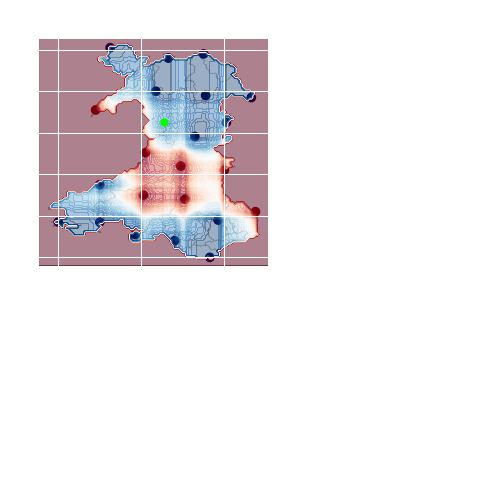

iteration  1
Accuracy is 0.5691213228225341
iteration  2
Accuracy is 0.5150932512978273
iteration  3
Accuracy is 0.6041145933474332
iteration  4
Accuracy is 0.70082676408383
iteration  5
Accuracy is 0.6890982503364738
iteration  6
Accuracy is 0.6867910017304365
iteration  7
Accuracy is 0.6989040569121323
iteration  8
Accuracy is 0.7761968852143819
iteration  9
Accuracy is 0.7515862334166507
iteration  10
Accuracy is 0.8375312439915401
iteration  11
Accuracy is 0.7861949625072101
iteration  12
Accuracy is 0.8152278407998462
iteration  13
Accuracy is 0.8336858296481446
iteration  14
Accuracy is 0.8336858296481446
iteration  15
Accuracy is 0.8217650451836185
iteration  16
Accuracy is 0.8181119015573928
iteration  17
Accuracy is 0.8194577965775812
iteration  18
Accuracy is 0.8146510286483368
iteration  19
Accuracy is 0.816189194385695
iteration  20
Accuracy is 0.8177273601230532
iteration  21
Accuracy is 0.8200346087290905
experiment:  13


<IPython.core.display.Javascript object>


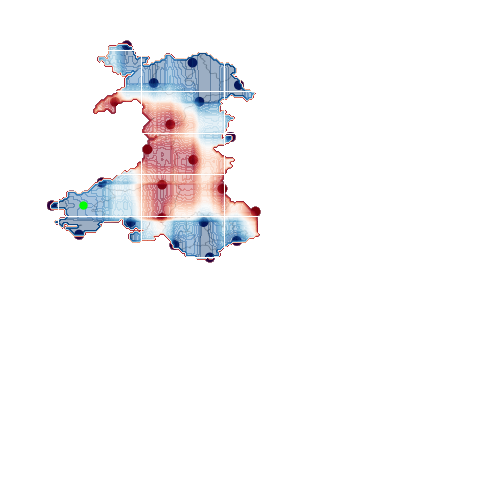

iteration  1
Accuracy is 0.5779657758123438
iteration  2
Accuracy is 0.5097096712170737
iteration  3
Accuracy is 0.602576427610075
iteration  4
Accuracy is 0.6865987310132666
iteration  5
Accuracy is 0.6756393001345895
iteration  6
Accuracy is 0.6423764660642184
iteration  7
Accuracy is 0.6508363776196885
iteration  8
Accuracy is 0.7388963660834454
iteration  9
Accuracy is 0.7552393770428764
iteration  10
Accuracy is 0.7919630840223034
iteration  11
Accuracy is 0.8190732551432417
iteration  12
Accuracy is 0.8131128629109786
iteration  13
Accuracy is 0.8359930782541819
iteration  14
Accuracy is 0.7936935204768314
iteration  15
Accuracy is 0.7696596808306095
iteration  16
Accuracy is 0.8023457027494713
iteration  17
Accuracy is 0.8404153047490868
iteration  18
Accuracy is 0.8550278792539896
iteration  19
Accuracy is 0.8450298019611613
iteration  20
Accuracy is 0.8696404537588925
iteration  21
Accuracy is 0.8875216304556816
experiment:  14


<IPython.core.display.Javascript object>


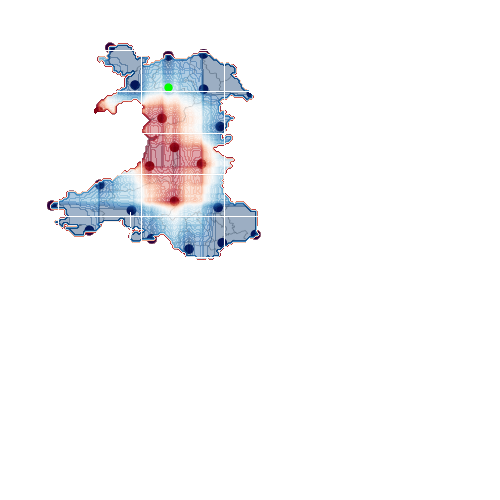

iteration  1
Accuracy is 0.5275908479138627
iteration  2
Accuracy is 0.6467986925591233
iteration  3
Accuracy is 0.6148817535089406
iteration  4
Accuracy is 0.6241107479330897
iteration  5
Accuracy is 0.7087098634877909
iteration  6
Accuracy is 0.7360123053258989
iteration  7
Accuracy is 0.7023649298211883
iteration  8
Accuracy is 0.7337050567198615
iteration  9
Accuracy is 0.7356277638915593
iteration  10
Accuracy is 0.7635070178811767
iteration  11
Accuracy is 0.7788886752547587
iteration  12
Accuracy is 0.7756200730628725
iteration  13
Accuracy is 0.773505095174005
iteration  14
Accuracy is 0.8181119015573928
iteration  15
Accuracy is 0.8140742164968275
iteration  16
Accuracy is 0.8546433378196501
iteration  17
Accuracy is 0.8356085368198424
iteration  18
Accuracy is 0.8242645645068256
iteration  19
Accuracy is 0.8525283599307826
iteration  20
Accuracy is 0.8248413766583349
iteration  21
Accuracy is 0.8309940396077677
experiment:  15


<IPython.core.display.Javascript object>


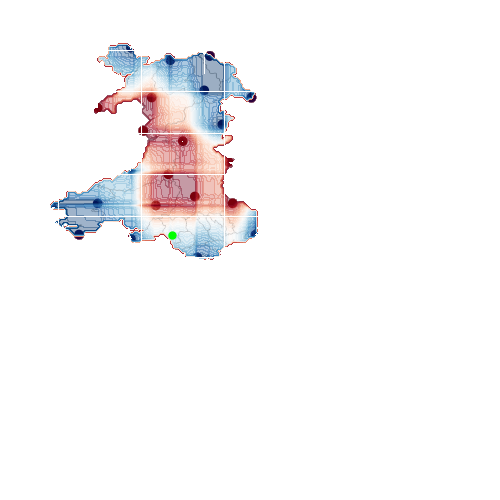

iteration  1
Accuracy is 0.539319361661219
iteration  2
Accuracy is 0.7994616419919246
iteration  3
Accuracy is 0.7310132666794847
iteration  4
Accuracy is 0.800038454143434
iteration  5
Accuracy is 0.792347625456643
iteration  6
Accuracy is 0.8127283214766391
iteration  7
Accuracy is 0.7233224379926937
iteration  8
Accuracy is 0.7039030955585465
iteration  9
Accuracy is 0.7773505095174005
iteration  10
Accuracy is 0.7798500288406076
iteration  11
Accuracy is 0.750432609113632
iteration  12
Accuracy is 0.7667756200730629
iteration  13
Accuracy is 0.7710055758507979
iteration  14
Accuracy is 0.7933089790424919
iteration  15
Accuracy is 0.8158046529513555
iteration  16
Accuracy is 0.8073447413958854
iteration  17
Accuracy is 0.84618342626418
iteration  18
Accuracy is 0.8513747356277639
iteration  19
Accuracy is 0.8432993655066333
iteration  20
Accuracy is 0.8538742549509709
iteration  21
Accuracy is 0.8490674870217266
experiment:  16


<IPython.core.display.Javascript object>


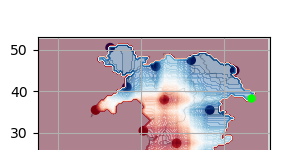

iteration  1
Accuracy is 0.5252835993078254
iteration  2
Accuracy is 0.7544702941741973
iteration  3
Accuracy is 0.7475485483560854
iteration  4
Accuracy is 0.759853874254951
iteration  5
Accuracy is 0.6654489521245914
iteration  6
Accuracy is 0.6402614881753509
iteration  7
Accuracy is 0.6475677754278023
iteration  8
Accuracy is 0.6733320515285522
iteration  9
Accuracy is 0.6406460296096904
iteration  10
Accuracy is 0.6577581234378004
iteration  11
Accuracy is 0.677754278023457
iteration  12
Accuracy is 0.705056719861565
iteration  13
Accuracy is 0.7283214766391078
iteration  14
Accuracy is 0.7385118246491059
iteration  15
Accuracy is 0.7177465871947702
iteration  16
Accuracy is 0.7675447029417419
iteration  17
Accuracy is 0.7996539127090944
iteration  18
Accuracy is 0.792347625456643
iteration  19
Accuracy is 0.8052297635070179
iteration  20
Accuracy is 0.8283022495673908
iteration  21
Accuracy is 0.8217650451836185
experiment:  17


<IPython.core.display.Javascript object>


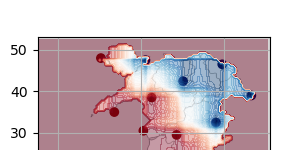

iteration  1
Accuracy is 0.5689290521053644
iteration  2
Accuracy is 0.587194770236493
iteration  3
Accuracy is 0.5860411459334743
iteration  4
Accuracy is 0.6250721015189387
iteration  5
Accuracy is 0.6466064218419535
iteration  6
Accuracy is 0.6842914824072294
iteration  7
Accuracy is 0.7271678523360892
iteration  8
Accuracy is 0.7644683714670256
iteration  9
Accuracy is 0.7635070178811767
iteration  10
Accuracy is 0.7010190348009998
iteration  11
Accuracy is 0.7031340126898673
iteration  12
Accuracy is 0.7412036146894828
iteration  13
Accuracy is 0.7821572774466449
iteration  14
Accuracy is 0.800038454143434
iteration  15
Accuracy is 0.8265718131128629
iteration  16
Accuracy is 0.8233032109209767
iteration  17
Accuracy is 0.8292636031532398
iteration  18
Accuracy is 0.84618342626418
iteration  19
Accuracy is 0.8006152662949433
iteration  20
Accuracy is 0.7927321668909825
iteration  21
Accuracy is 0.7796577581234378
experiment:  18


<IPython.core.display.Javascript object>


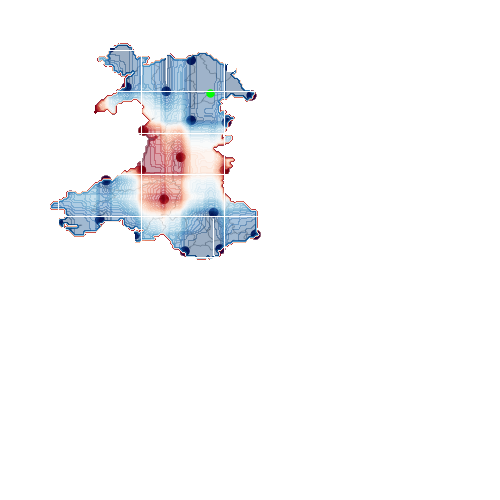

iteration  1
Accuracy is 0.476062295712363
iteration  2
Accuracy is 0.52143818496443
iteration  3
Accuracy is 0.6865987310132666
iteration  4
Accuracy is 0.7783118631032494
iteration  5
Accuracy is 0.720438377235147
iteration  6
Accuracy is 0.7194770236492982
iteration  7
Accuracy is 0.7631224764468372
iteration  8
Accuracy is 0.6873678138819458
iteration  9
Accuracy is 0.7014035762353393
iteration  10
Accuracy is 0.7012113055181696
iteration  11
Accuracy is 0.7100557585079792
iteration  12
Accuracy is 0.7413958854066526
iteration  13
Accuracy is 0.830801768890598
iteration  14
Accuracy is 0.8327244760622957
iteration  15
Accuracy is 0.842722553355124
iteration  16
Accuracy is 0.8352239953855027
iteration  17
Accuracy is 0.8417611997692751
iteration  18
Accuracy is 0.8429148240722938
iteration  19
Accuracy is 0.8298404153047491
iteration  20
Accuracy is 0.8271486252643723
iteration  21
Accuracy is 0.8202268794462604
experiment:  19


<IPython.core.display.Javascript object>


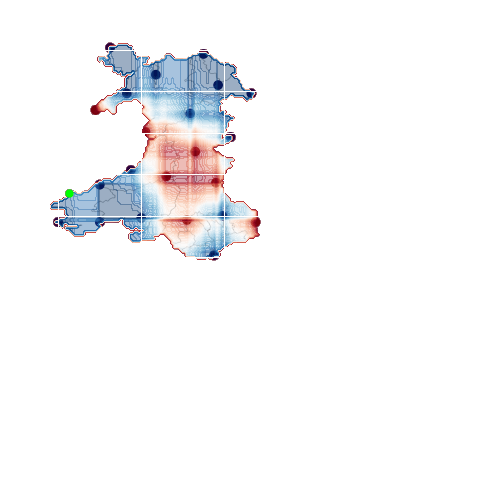

iteration  1
Accuracy is 0.5762353393578158
iteration  2
Accuracy is 0.5168236877523553
iteration  3
Accuracy is 0.6281484329936551
iteration  4
Accuracy is 0.717169775043261
iteration  5
Accuracy is 0.6692943664679869
iteration  6
Accuracy is 0.784656796769852
iteration  7
Accuracy is 0.7323591616996732
iteration  8
Accuracy is 0.775235531628533
iteration  9
Accuracy is 0.7254374158815612
iteration  10
Accuracy is 0.7946548740626802
iteration  11
Accuracy is 0.7708133051336281
iteration  12
Accuracy is 0.7275523937704288
iteration  13
Accuracy is 0.8131128629109786
iteration  14
Accuracy is 0.8125360507594693
iteration  15
Accuracy is 0.8373389732743703
iteration  16
Accuracy is 0.8329167467794655
iteration  17
Accuracy is 0.8348394539511632
iteration  18
Accuracy is 0.8302249567390886
iteration  19
Accuracy is 0.817150547971544
iteration  20
Accuracy is 0.8067679292443761
iteration  21
Accuracy is 0.8198423380119207
experiment:  20


<IPython.core.display.Javascript object>


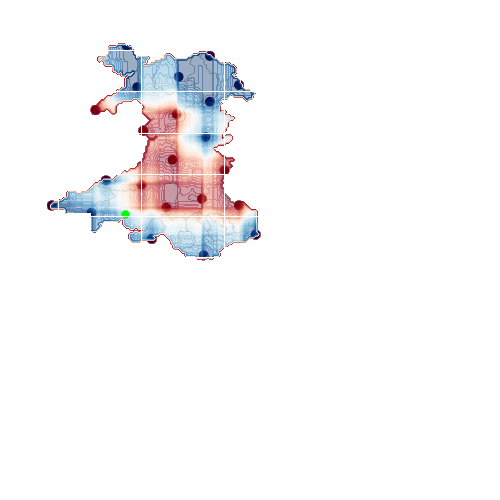

iteration  1
Accuracy is 0.4922130359546241
iteration  2
Accuracy is 0.5558546433378196
iteration  3
Accuracy is 0.6748702172659105
iteration  4
Accuracy is 0.693135935397039
iteration  5
Accuracy is 0.7892712939819265
iteration  6
Accuracy is 0.7975389348202269
iteration  7
Accuracy is 0.8375312439915401
iteration  8
Accuracy is 0.7548548356085368
iteration  9
Accuracy is 0.771774658719477
iteration  10
Accuracy is 0.7558161891943856
iteration  11
Accuracy is 0.7800422995577774
iteration  12
Accuracy is 0.7698519515477793
iteration  13
Accuracy is 0.7921553547394732
iteration  14
Accuracy is 0.8248413766583349
iteration  15
Accuracy is 0.8292636031532398
iteration  16
Accuracy is 0.8233032109209767
iteration  17
Accuracy is 0.8248413766583349
iteration  18
Accuracy is 0.8396462218804076
iteration  19
Accuracy is 0.8465679676985195
iteration  20
Accuracy is 0.8550278792539896
iteration  21
Accuracy is 0.8548356085368198


In [7]:
from random import randint
import time

valid_seeds = [4,27,12,15,17,21,23,24,25,28,31,32,35,36,37,41,42,43,45,48,420]

Results = []

for j in range(len(valid_seeds)):
    
    random.seed(valid_seeds[j])

    print('experiment: ',j)                            

    num = 100
    x = np.linspace(-5, 51, num)
    y = np.linspace(-2, 53, num)
    global landpoints 
    landpoints = []

    for i in range(num):
        for j in range(num):
            if wales.contains_points([(x[i],y[j])]):
                landpoints.append([x[i],y[j]])

    landpoints = np.asarray(landpoints, dtype=np.float32)

    i=0 
    coords = []

    for i in range(numcoords):
        value = randint(0, landpoints.size/2)
        coords.append((landpoints[value][0],
                            landpoints[value][1],
                            braninColor(landpoints[value],threshold)))
        i+=1

    global fig1,ax
    fig1, ax = plt.subplots(figsize = (3,3))
    ax.set_xlim(-5,51)
    ax.set_ylim(-2,53)
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic')
    # plt.axis("off")
    plt.grid()
    # cid = fig1.canvas.mpl_connect('button_press_event', Helicopter)

    fig1.show()
    fig1.canvas.draw()

    global accuracyArray
    accuracyArray = []

    for i in range(maxiter):
        plt.pause(1)
        print('iteration ',i+1)
    #     print('Calculating Model... ')
        calculateModel()
        plt.pause(1)
        fig1.canvas.draw()    
        Accuracy()
    #     print('Finding Isolated Point')
        if(i!=maxiter):
                     #0 for 0.5, 1 for isolated, 2 for random

            if(selection_model == 0):    
                nextpoint = find0_5()
            elif(selection_model==1):
                nextpoint=find_isolated_point()
            elif(selection_model==2):
                nextpoint = random_point()
            elif(selection_model==3):
                nextpoint = best()
            plt.pause(1)
            fig1.canvas.draw()
            coords.append((nextpoint[0], nextpoint[1], braninColor(nextpoint,threshold)))  
            plt.pause(1)
            fig1.canvas.draw()

    plt.close()
    
    Results.append(accuracyArray)
    
    

In [8]:
print('Highest Accuracy =',"{:.2f}".format((max(accuracyArray)*100)),'%')
print('Improvement is =', "{:.2f}".format((max(accuracyArray)-accuracyArray[0])*100),'%')

Highest Accuracy = 85.50 %
Improvement is = 36.28 %


In [9]:
Results

[[0.5141318977119784,
  0.485483560853682,
  0.6308402230340319,
  0.6546817919630841,
  0.7271678523360892,
  0.690636416073832,
  0.7686983272447606,
  0.7388963660834454,
  0.7656219957700442,
  0.7790809459719285,
  0.8294558738704095,
  0.8198423380119207,
  0.8319553931936167,
  0.8113824264564506,
  0.8319553931936167,
  0.798308017688906,
  0.8133051336281484,
  0.8075370121130552,
  0.8071524706787157,
  0.8663718515670064,
  0.8390694097288983],
 [0.4879830801768891,
  0.5583541626610268,
  0.5389348202268794,
  0.6318015766198808,
  0.7810036531436262,
  0.7819650067294751,
  0.7756200730628725,
  0.7106325706594886,
  0.7277446644875986,
  0.8561815035570083,
  0.8258027302441838,
  0.8365698904056912,
  0.8300326860219188,
  0.8398384925975774,
  0.8304172274562585,
  0.7979234762545664,
  0.7921553547394732,
  0.7817727360123053,
  0.848682945587387,
  0.8204191501634301,
  0.8217650451836185],
 [0.4814458757931167,
  0.6969813497404346,
  0.7460103826187272,
  0.69717362

In [10]:
np.savetxt('BraninIsolatedpls', Results)

In [11]:
tst = np.loadtxt('BraninIsolated')

OSError: BraninIsolated not found.

In [ ]:
import random
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import seaborn as sns

# define a and b here
a = tst
b = []
for i in range(21):
    b.append(i+1)

# Helps pick a random color for each plot, used for readability
rand = lambda: random.randint(0, 255)
fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(111)
ax.set(ylim=(0.4, 1))

for ydata in a:
    clr = '#%02X%02X%02X' % (rand(),rand(),rand())
    plot, = ax.plot(b, ydata, color=clr, alpha = 0.2)
    sns.boxplot(data=tst)